In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer  
from scipy.stats import ttest_ind
from scipy.stats import pearsonr

In [110]:
file = pd.read_csv("social_media_vs_productivity.csv")
df = pd.DataFrame(file)
print("Shape", df.shape)

Shape (30000, 19)


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         27235 non-null  float64
 4   social_platform_preference      30000 non-null  object 
 5   number_of_notifications         30000 non-null  int64  
 6   work_hours_per_day              30000 non-null  float64
 7   perceived_productivity_score    28386 non-null  float64
 8   actual_productivity_score       27635 non-null  float64
 9   stress_level                    28096 non-null  float64
 10  sleep_hours                     27402 non-null  float64
 11  screen_time_before_sleep        27789 non-null  float64
 12  breaks_during_work              

In [112]:
df.isnull().sum().sort_values(ascending=False)

daily_social_media_time           2765
job_satisfaction_score            2730
sleep_hours                       2598
actual_productivity_score         2365
screen_time_before_sleep          2211
stress_level                      1904
perceived_productivity_score      1614
work_hours_per_day                   0
number_of_notifications              0
gender                               0
social_platform_preference           0
job_type                             0
breaks_during_work                   0
uses_focus_apps                      0
has_digital_wellbeing_enabled        0
coffee_consumption_per_day           0
days_feeling_burnout_per_month       0
weekly_offline_hours                 0
age                                  0
dtype: int64

In [113]:
# Median for skewed variables
median_cols = ['sleep_hours', 'screen_time_before_sleep']
df[median_cols] = df[median_cols].fillna(df[median_cols].median())

# Mean for score-like variables
mean_cols = ['job_satisfaction_score', 'actual_productivity_score', 'stress_level', 'perceived_productivity_score']
df[mean_cols] = df[mean_cols].fillna(df[mean_cols].mean())

In [114]:
df_clean = df.dropna(subset=[
    'daily_social_media_time', 
    'perceived_productivity_score',
    'actual_productivity_score']).copy()

df_clean['daily_social_media_time'] = pd.to_numeric(df_clean['daily_social_media_time'], errors='coerce')

df_clean[[
    'daily_social_media_time', 
    'perceived_productivity_score',
    'actual_productivity_score']].describe()

,daily_social_media_time,perceived_productivity_score,actual_productivity_score
count,27235.000000,27235.000000,27235.000000
mean,3.113418,5.508996,4.948586
std,2.074813,1.968526,1.808253
min,0.000000,2.000252,0.296812
25%,1.639566,3.857854,3.504360
50%,3.025913,5.510488,4.951805
75%,4.368917,7.164801,6.394007
max,17.973256,8.999376,9.846258


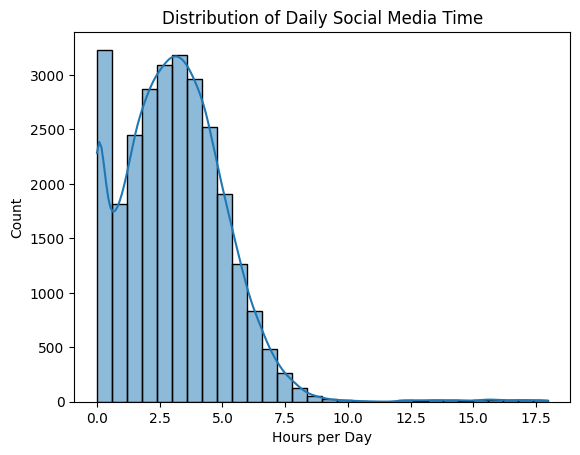

In [123]:
sns.histplot(df_clean['daily_social_media_time'], kde=True, bins=30)
plt.title("Distribution of Daily Social Media Time")
plt.xlabel("Hours per Day")
plt.show()

In [116]:
df_clean.loc[:, 'productivity_gap'] = (
    df_clean['perceived_productivity_score'] - df_clean['actual_productivity_score']
)

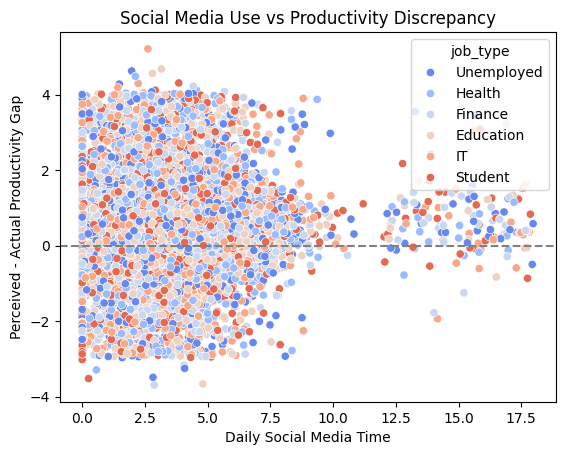

In [124]:
sns.scatterplot(
    data=df_clean,
    x='daily_social_media_time',
    y='productivity_gap',
    hue='job_type',
    palette='coolwarm'
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Social Media Use vs Productivity Discrepancy")
plt.xlabel("Daily Social Media Time")
plt.ylabel("Perceived - Actual Productivity Gap")
plt.show()

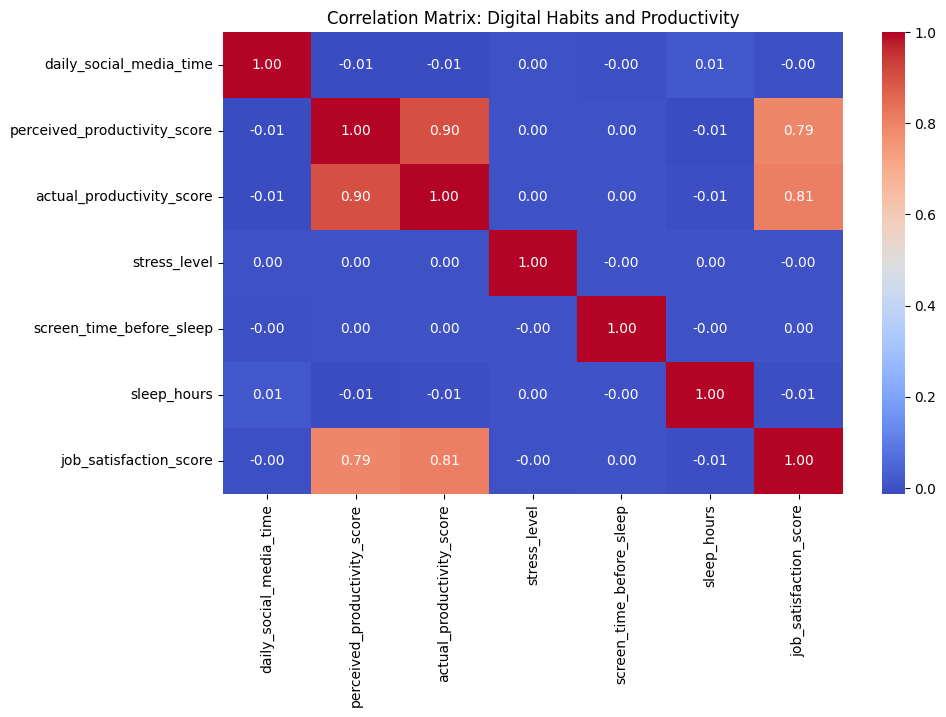

In [118]:
corr_vars = [
    'daily_social_media_time',
    'perceived_productivity_score',
    'actual_productivity_score',
    'stress_level',
    'screen_time_before_sleep',
    'sleep_hours',
    'job_satisfaction_score'
]

corr_matrix = df_clean[corr_vars].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix: Digital Habits and Productivity")
plt.show()

In [119]:
df[['daily_social_media_time', 'perceived_productivity_score']].corr()

,daily_social_media_time,perceived_productivity_score
daily_social_media_time,1.00000,-0.01093
perceived_productivity_score,-0.01093,1.00000


In [120]:
# Conduct Pearson's correlation test. This also shows us that people's perceived productivity
# does not change with more or less time spent on social media
corr, p_value = pearsonr(df_clean['daily_social_media_time'], df_clean['perceived_productivity_score'])
print(f"Correlation: {corr:.3f}, p-value: {p_value:.3f}")


Correlation: -0.011, p-value: 0.071


In [121]:
#Separate social media users by high and low
df['social_media_group'] = df['daily_social_media_time'].apply(lambda x: 'High' if x > 4 else 'Low')

df.groupby('social_media_group')['actual_productivity_score'].describe()


,count,mean,std,min,25%,50%,75%,max
social_media_group,,,,,,,,
High,8537.0,4.937262,1.808934,0.529287,3.502043,4.951805,6.378156,9.510820
Low,21463.0,4.957589,1.807100,0.296812,3.512790,4.951805,6.404630,9.846258


In [122]:
# Conduct a t-test: There’s no evidence to suggest that people who spend 
# more time on social media are less productive
high = df[df['social_media_group'] == 'High']['actual_productivity_score']
low = df[df['social_media_group'] == 'Low']['actual_productivity_score']

t_stat, p_val = ttest_ind(high, low)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: -0.8788535157377048, P-value: 0.37948774482525205
